# Classification
### Predicting wheather an individual is likely to seek mental health treatment.

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, chi2, f_classif
import warnings
warnings.filterwarnings('ignore')

### Loading the Dataset

In [2]:
df = pd.read_csv('mental_health_cleaned.csv')

print("Dataset shape:", df.shape)
print("\nTarget variable distribution:")
print(df['treatment'].value_counts())

Dataset shape: (1259, 27)

Target variable distribution:
treatment
Yes    637
No     622
Name: count, dtype: int64


### Data Preprocessing 

In [3]:
df_encoded = df.copy()
# Identifying and handling different column types
categorical_columns = []
for col in df.columns:
    if df[col].dtype == 'object' and col != 'treatment':
        categorical_columns.append(col)

print(f"Found {len(categorical_columns)} categorical columns: {categorical_columns}")

# Removing comments and other columns which aren't useful in classification
columns_to_drop = []
for col in ['timestamp', 'Timestamp', 'comments']:
    if col in df_encoded.columns:
        columns_to_drop.append(col)

if columns_to_drop:
    df_encoded = df_encoded.drop(columns_to_drop, axis=1)
    categorical_columns = [col for col in categorical_columns if col not in columns_to_drop]
    print(f"Dropped columns: {columns_to_drop}")

Found 25 categorical columns: ['timestamp', 'gender', 'country', 'state', 'self_employed', 'family_history', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'comments']
Dropped columns: ['timestamp', 'comments']


### Encode categorical variables with better handling

In [4]:
le_dict = {}
for col in categorical_columns:
    le = LabelEncoder()
    # Handle missing values
    df_encoded[col] = df_encoded[col].fillna('Unknown')
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    le_dict[col] = le

# Encode target variable
if df_encoded['treatment'].dtype == 'object':
    le_target = LabelEncoder()
    df_encoded['treatment'] = le_target.fit_transform(df_encoded['treatment'])
    print("Target variable encoded: 0 = No Treatment, 1 = Treatment")

# Handle any remaining missing values in numerical columns
df_encoded = df_encoded.fillna(df_encoded.median())

# Separate features and target - Using DataFrame instead of converting to numpy
X = df_encoded.drop('treatment', axis=1)
y = df_encoded['treatment']

print(f"\nFeatures used: {list(X.columns)}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Target variable encoded: 0 = No Treatment, 1 = Treatment

Features used: ['age', 'gender', 'country', 'state', 'self_employed', 'family_history', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence']
Feature matrix shape: (1259, 24)
Target vector shape: (1259,)


### Feature Selection - Remove low variance and irrelevant features

In [5]:
low_variance_cols = []
for col in X.columns:
    if X[col].var() < 0.01:  # Very low variance
        low_variance_cols.append(col)

if low_variance_cols:
    print(f"Removing low variance features: {low_variance_cols}")
    X = X.drop(low_variance_cols, axis=1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 1007 samples
Test set: 252 samples


### Feature Scaling

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for some models
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

### Initializing Models

In [7]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=2000, C=0.1),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=8, min_samples_split=10, min_samples_leaf=5),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=7, weights='distance'),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_split=10),
    'SVM': SVC(random_state=42, probability=True, kernel='rbf', C=1.0)
}

### Training

In [8]:
results = {}
model_predictions = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    
    try:
        if name in ['K-Nearest Neighbors', 'SVM']:
            # Use scaled data for distance-based models
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            # Use original data for tree-based models (it works better as said in blogs :) 
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'roc_auc': roc_auc
        }
        
        model_predictions[name] = {
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"ROC-AUC Score: {roc_auc:.4f}")
        
    except Exception as e:
        print(f"Error training {name}: {str(e)}")
        continue


Training Logistic Regression...
Accuracy: 0.7024
ROC-AUC Score: 0.7586

Training Decision Tree...
Accuracy: 0.7183
ROC-AUC Score: 0.7837

Training K-Nearest Neighbors...
Accuracy: 0.6746
ROC-AUC Score: 0.7201

Training Random Forest...
Accuracy: 0.7381
ROC-AUC Score: 0.8070

Training SVM...
Accuracy: 0.7063
ROC-AUC Score: 0.7630


### Hyperparameter tuning for best models
i just learned about hyperparameters and wanted to try it in my Capstone project

In [9]:
print(f"\n{'='*50}")
print("HYPERPARAMETER TUNING")
print(f"{'='*50}")

# Finding current best model
if results:
    best_model_name = max(results.keys(), key=lambda x: results[x]['roc_auc'])
    print(f"Current best model: {best_model_name} with ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
    
    # Hyperparameter tuning for top performing models
    param_grids = {
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [5, 10, 20],
            'min_samples_leaf': [2, 5, 10]
        },
        'Logistic Regression': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'lbfgs']
        }
    }
    
    # Tune the best performing models
    tuned_models = {}
    for model_name in ['Random Forest', 'Logistic Regression']:
        if model_name in results:
            print(f"\nTuning {model_name}...")
            
            if model_name == 'Random Forest':
                base_model = RandomForestClassifier(random_state=42)
                grid_search = GridSearchCV(base_model, param_grids[model_name], 
                                         cv=3, scoring='roc_auc', n_jobs=-1)
                grid_search.fit(X_train, y_train)
            else:  # Logistic Regression
                base_model = LogisticRegression(random_state=42, max_iter=2000)
                grid_search = GridSearchCV(base_model, param_grids[model_name], 
                                         cv=3, scoring='roc_auc', n_jobs=-1)
                grid_search.fit(X_train_scaled, y_train)
            
            # Evaluate tuned model
            if model_name == 'Random Forest':
                y_pred_tuned = grid_search.predict(X_test)
                y_pred_proba_tuned = grid_search.predict_proba(X_test)[:, 1]
            else:
                y_pred_tuned = grid_search.predict(X_test_scaled)
                y_pred_proba_tuned = grid_search.predict_proba(X_test_scaled)[:, 1]
            
            accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
            roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
            
            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Tuned Accuracy: {accuracy_tuned:.4f}")
            print(f"Tuned ROC-AUC: {roc_auc_tuned:.4f}")
            print(f"Improvement: {roc_auc_tuned - results[model_name]['roc_auc']:+.4f}")
            
            tuned_models[f"{model_name} (Tuned)"] = {
                'model': grid_search.best_estimator_,
                'accuracy': accuracy_tuned,
                'roc_auc': roc_auc_tuned
            }
            
            model_predictions[f"{model_name} (Tuned)"] = {
                'y_pred': y_pred_tuned,
                'y_pred_proba': y_pred_proba_tuned
            }

# Update results with tuned models
results.update(tuned_models)


HYPERPARAMETER TUNING
Current best model: Random Forest with ROC-AUC: 0.8070

Tuning Random Forest...
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Tuned Accuracy: 0.7262
Tuned ROC-AUC: 0.8138
Improvement: +0.0069

Tuning Logistic Regression...
Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Tuned Accuracy: 0.6825
Tuned ROC-AUC: 0.7539
Improvement: -0.0047


#### well hyperparameter tuning didnt improve accuracy too much , maybe its the dataset

### The Best Model :

In [10]:
if results:
    best_model_name = max(results.keys(), key=lambda x: results[x]['roc_auc'])
    best_model = results[best_model_name]
    best_predictions = model_predictions[best_model_name]

    print(f"\n{'='*60}")
    print(f"BEST MODEL: {best_model_name}")
    print(f"Best ROC-AUC Score: {best_model['roc_auc']:.4f}")
    print(f"Best Accuracy: {best_model['accuracy']:.4f}")

    # Detailed evaluation of best model
    print(f"\n{best_model_name} - Detailed Results:")
    print("\nClassification Report:")
    print(classification_report(y_test, best_predictions['y_pred']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, best_predictions['y_pred'])
    print(f"\nConfusion Matrix:")
    print(cm)

    # Feature importance for tree-based models (needed for blog and report we should know what features were most relevant right)
    if hasattr(best_model['model'], 'feature_importances_'):
        print(f"\nTop 10 Most Important Features:")
        feature_names = list(X.columns)
        importances = best_model['model'].feature_importances_
        feature_importance = list(zip(feature_names, importances))
        feature_importance.sort(key=lambda x: x[1], reverse=True)
        
        for i, (feature, importance) in enumerate(feature_importance[:10]):
            print(f"{i+1:2d}. {feature:25s}: {importance:.4f}")


BEST MODEL: Random Forest (Tuned)
Best ROC-AUC Score: 0.8138
Best Accuracy: 0.7262

Random Forest (Tuned) - Detailed Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.77      0.73       124
           1       0.75      0.69      0.72       128

    accuracy                           0.73       252
   macro avg       0.73      0.73      0.73       252
weighted avg       0.73      0.73      0.73       252


Confusion Matrix:
[[95 29]
 [40 88]]

Top 10 Most Important Features:
 1. family_history           : 0.1672
 2. work_interfere           : 0.1369
 3. age                      : 0.0871
 4. care_options             : 0.0768
 5. state                    : 0.0466
 6. benefits                 : 0.0466
 7. country                  : 0.0460
 8. no_employees             : 0.0450
 9. leave                    : 0.0402
10. mental_health_consequence: 0.0339


## Graphs and Visualizations
### Best Model Plot

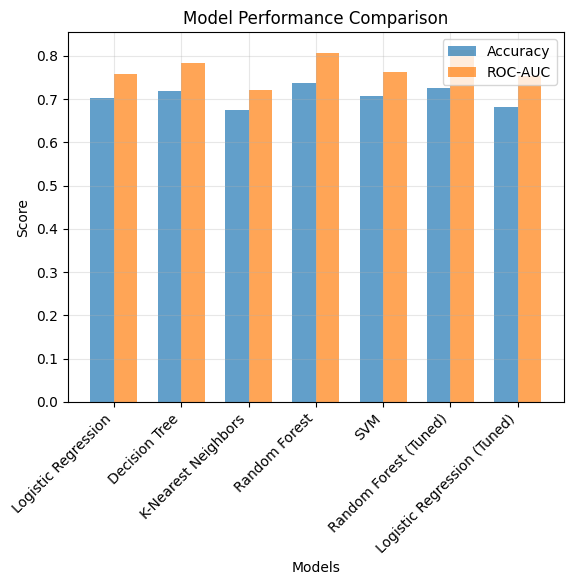

In [11]:
    
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]
    roc_scores = [results[name]['roc_auc'] for name in model_names]

    x_pos = np.arange(len(model_names))
    width = 0.35
    plt.bar(x_pos - width/2, accuracies, width, label='Accuracy', alpha=0.7)
    plt.bar(x_pos + width/2, roc_scores, width, label='ROC-AUC', alpha=0.7)
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x_pos, model_names, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

### Confusion Matrix Plot

Text(0.5, 23.52222222222222, 'Predicted Label')

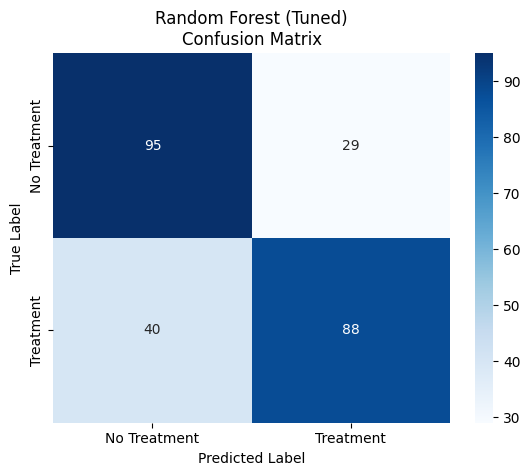

In [12]:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
    xticklabels=['No Treatment', 'Treatment'],
    yticklabels=['No Treatment', 'Treatment'])
    plt.title(f'{best_model_name}\nConfusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

### ROC Curve

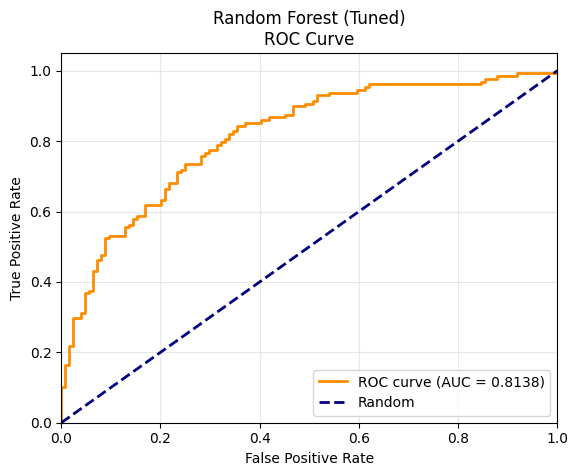

In [13]:
    fpr, tpr, _ = roc_curve(y_test, best_predictions['y_pred_proba'])
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {best_model["roc_auc"]:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{best_model_name}\nROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

### Feature Importance Graph Visuals

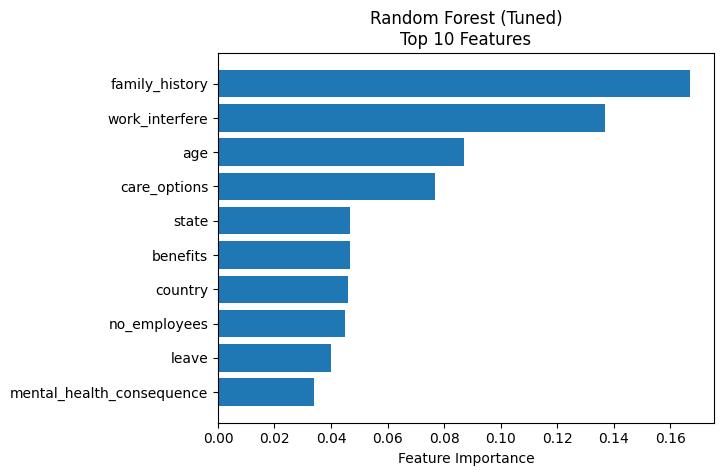

In [14]:
if hasattr(best_model['model'], 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': best_model['model'].feature_importances_
        }).sort_values('importance', ascending=False).head(10)
        
        plt.barh(range(len(importance_df)), importance_df['importance'])
        plt.yticks(range(len(importance_df)), importance_df['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'{best_model_name}\nTop 10 Features')
        plt.gca().invert_yaxis()


### Conclusion

In [15]:
    print(f"\n{'='*60}")
    print("FINAL CLASSIFICATION SUMMARY")
    print(f"{'='*60}")
    print(f"Dataset size: {len(df)} samples")
    print(f"Number of features after preprocessing: {X.shape[1]}")
    print(f"Models tested: {len(results)}")
    print(f"Best performing model: {best_model_name}")


FINAL CLASSIFICATION SUMMARY
Dataset size: 1259 samples
Number of features after preprocessing: 24
Models tested: 7
Best performing model: Random Forest (Tuned)


In [17]:
import joblib
joblib.dump('Random Forest', "Classification_model.pkl")

['Classification_model.pkl']